In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder,RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
import pickle

## Data Loading

In [2]:
data=pd.read_csv("Electric_Car.csv")

## Data preprocessing

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Brand            103 non-null    object 
 1   Model            103 non-null    object 
 2   AccelSec         103 non-null    float64
 3   TopSpeed_KmH     103 non-null    int64  
 4   Range_Km         103 non-null    int64  
 5   Efficiency_WhKm  103 non-null    int64  
 6   FastCharge_KmH   103 non-null    object 
 7   RapidCharge      103 non-null    object 
 8   PowerTrain       103 non-null    object 
 9   PlugType         103 non-null    object 
 10  BodyStyle        103 non-null    object 
 11  Segment          103 non-null    object 
 12  Seats            103 non-null    int64  
 13  PriceEuro        103 non-null    int64  
dtypes: float64(1), int64(5), object(8)
memory usage: 11.4+ KB


In [4]:
data.shape

(103, 14)

In [5]:
data.isna().sum()

Brand              0
Model              0
AccelSec           0
TopSpeed_KmH       0
Range_Km           0
Efficiency_WhKm    0
FastCharge_KmH     0
RapidCharge        0
PowerTrain         0
PlugType           0
BodyStyle          0
Segment            0
Seats              0
PriceEuro          0
dtype: int64

In [6]:
data.duplicated().sum()

0

In [7]:
data.dtypes

Brand               object
Model               object
AccelSec           float64
TopSpeed_KmH         int64
Range_Km             int64
Efficiency_WhKm      int64
FastCharge_KmH      object
RapidCharge         object
PowerTrain          object
PlugType            object
BodyStyle           object
Segment             object
Seats                int64
PriceEuro            int64
dtype: object

In [8]:
# Convert the Fast charge Datatype to Numeric
data['FastCharge_KmH'] = pd.to_numeric(data['FastCharge_KmH'], errors='coerce')

In [9]:
data.drop(['Model', 'Seats','TopSpeed_KmH'], axis=1, inplace=True)

In [10]:
data.head()

,Brand,AccelSec,Range_Km,Efficiency_WhKm,FastCharge_KmH,RapidCharge,PowerTrain,PlugType,BodyStyle,Segment,PriceEuro
0,Tesla,4.6,450,161,940.0,Yes,AWD,Type 2 CCS,Sedan,D,55480
1,Volkswagen,10.0,270,167,250.0,Yes,RWD,Type 2 CCS,Hatchback,C,30000
2,Polestar,4.7,400,181,620.0,Yes,AWD,Type 2 CCS,Liftback,D,56440
3,BMW,6.8,360,206,560.0,Yes,RWD,Type 2 CCS,SUV,D,68040
4,Honda,9.5,170,168,190.0,Yes,RWD,Type 2 CCS,Hatchback,B,32997


In [11]:
data.describe()

,AccelSec,Range_Km,Efficiency_WhKm,FastCharge_KmH,PriceEuro
count,103.000000,103.000000,103.000000,98.000000,103.000000
mean,7.396117,338.786408,189.165049,456.734694,55811.563107
std,3.017430,126.014444,29.566839,201.262897,34134.665280
min,2.100000,95.000000,104.000000,170.000000,20129.000000
25%,5.100000,250.000000,168.000000,275.000000,34429.500000
50%,7.300000,340.000000,180.000000,440.000000,45000.000000
75%,9.000000,400.000000,203.000000,560.000000,65000.000000
max,22.400000,970.000000,273.000000,940.000000,215000.000000


## Data Segregration

In [12]:
y=data['PriceEuro']
X=data.drop('PriceEuro',axis=1)
num_data=X.select_dtypes(include=np.number)
cat_data=X.select_dtypes(exclude=np.number)

In [13]:
num_data.skew()

AccelSec           1.245309
Range_Km           1.378960
Efficiency_WhKm    0.871567
FastCharge_KmH     0.649778
dtype: float64

In [14]:
for col in num_data.columns:
    num_data[col] = np.log1p(num_data[col])


In [15]:
num_data.skew()

AccelSec          -0.287009
Range_Km          -0.717389
Efficiency_WhKm    0.226210
FastCharge_KmH    -0.195036
dtype: float64

In [16]:
y.skew()

2.2219311943227185

In [17]:
y=np.log1p(y)

In [18]:
y.skew()

0.7423381406973911

## Pipeline creation:

In [19]:
num_cols= num_data.columns.to_list()
cat_cols=cat_data.columns.to_list()

In [20]:
# spliting data into train & validation set
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=48)

<IPython.core.display.Javascript object>

## Defining Data processing & Modeling Pipeline

In [21]:
from sklearn.preprocessing import RobustScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])


In [23]:
# pipeline for categorical faetures - missing category replacement by new category i.e. missing followed by one hot encoding 
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('one_hot', OneHotEncoder(handle_unknown='ignore'))
])


In [24]:
# Create pipeline for the data
data_pipeline = ColumnTransformer([
    ('numeric', num_pipeline, num_cols),
    ('categorical', cat_pipeline, cat_cols)
], remainder='passthrough')


In [25]:
data_pipeline

ColumnTransformer(remainder='passthrough',
                  transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', RobustScaler())]),
                                 ['AccelSec', 'Range_Km', 'Efficiency_WhKm',
                                  'FastCharge_KmH']),
                                ('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='Missing',
                                                                strategy='constant')),
                                                 ('one_hot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Brand', 'RapidCharge', 'PowerTrain',
                                  'PlugType', 'BodyStyle', 'Segment'])])

In [26]:
# Full model pipeline
full_pipe = Pipeline([
    ('pre_process', data_pipeline),
    ('model', LinearRegression())
])

In [27]:
full_pipe

Pipeline(steps=[('pre_process',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['AccelSec', 'Range_Km',
                                                   'Efficiency_WhKm',
                                                   'FastCharge_KmH']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('one_hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Brand', 'RapidCharge',
                                                   'PowerTrain', 'PlugType',
                                                   'BodyStyle', 'Segment'])])),
                ('model', LinearRegression())])

In [28]:
full_pipe.fit(X_train, y_train)

Pipeline(steps=[('pre_process',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['AccelSec', 'Range_Km',
                                                   'Efficiency_WhKm',
                                                   'FastCharge_KmH']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('one_hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Brand', 'RapidCharge',
                                                   'PowerTrain', 'PlugType',
                                                   'BodyStyle', 'Segment'])])),
                ('model', LinearRegression())])

In [29]:
full_pipe.score(X_train, y_train)

0.9961604754809086

In [30]:
# Get predictions from the pipeline
y_pred = full_pipe.predict(X_train)

# Compute residuals
residuals = y_train - y_pred


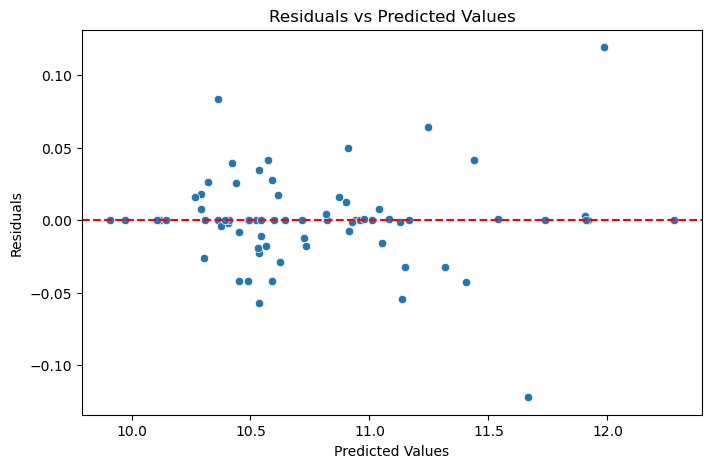

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()


In [32]:
with open('Ev_num_data.pkl', 'wb') as f:
    pickle.dump(num_pipeline, f)
with open('Ev_cat_data.pkl', 'wb') as f:
    pickle.dump(cat_pipeline, f)
with open('EV_full_pipeline_SP.pkl', 'wb') as f:
    pickle.dump(full_pipe, f)